In [1]:
cd C:\Data\20170412\p4_1

C:\Data\20170412\p4_1


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py as h5py
import glob as glob
import numpy as np
import scipy.io
import sys
sys.path.append('C://Users/Ginty Lab/My Documents/Github/kwik-tools')
import read_rhd as rhd
import klusta
from klusta.kwik import KwikModel
kwik_path = 'C:/DATA/20170412/p4_1/brushPress_170412_.kwik'
model = KwikModel(kwik_path)

In [3]:
good = []

for k in model.cluster_groups.keys():
    if model.cluster_groups[k] == 'good':
        good.append(k)

In [4]:
times = model.spike_times
spikes = model.spike_clusters
goodspikes = []
goodtimes = []
good = sorted(good)
for i,n in enumerate(spikes):
    if n in good:
        goodtimes.append(times[i])
        goodspikes.append(good.index(spikes[i]))

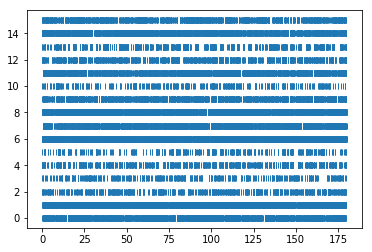

In [5]:
ltime = 0 # in seconds
rtime = 180 # in seconds
goodtimes = np.array(goodtimes)
goodspikes = np.array(goodspikes)
plt.plot(goodtimes[(goodtimes > ltime) & (goodtimes < rtime)],goodspikes[(goodtimes > ltime) & (goodtimes < rtime)],'|')

In [6]:
import load_intan_input_channels as liic

In [7]:
[di,ai] = liic.load_intan_input_channels()

In [8]:
#load traces from nidaq and break out into variables
a = scipy.io.matlab.loadmat("acquireIntanBrush_170412 1303 42.mat")
matlab_brush = a['data'][:,0]
matlab_sync = a['data'][:,1]
matlab_sync[matlab_sync < 1.5] = 0
matlab_sync[matlab_sync > 1.5] = 1

# load traces from intan and break out into variables
intan_sync = di['1']
intan_trigger = di['0']

In [9]:
matlab_brush_extra_added = np.append(np.zeros(20263),matlab_brush) # calculated by comparing first transitions in sync signal
matlab_sync_extra_added = np.append(np.ones(20263), matlab_sync)

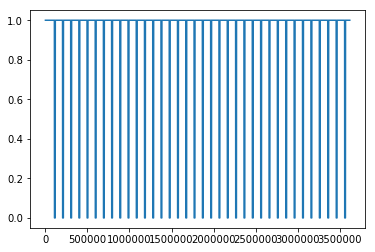

In [10]:
#plt.plot(matlab_brush_extra_added)
plt.plot(matlab_sync_extra_added)

In [11]:
matlab_transitions = (np.where(matlab_sync_extra_added[:-1] != matlab_sync_extra_added[1:])[0])
intan_transitions = (np.where(intan_sync[:-1] != intan_sync[1:])[0])
print(intan_transitions[0:10])
print(matlab_transitions[0:10])
print((matlab_transitions - np.roll(matlab_transitions, 1))/20000)
print((intan_transitions - np.roll(intan_transitions, 1))/20000)

[  9697  19700 106526 116529 203454 213457 300483 310486 397611 407615]
[106528 116531 203457 213461 300487 310490 397616 407620 494846 504849]
[-173.1025     0.50015    4.3463     0.5002     4.3513     0.50015
    4.3563     0.5002     4.3613     0.50015    4.36635    0.50015
    4.3713     0.5002     4.3763     0.5002     4.3813     0.50015
    4.38635    0.50015    4.3913     0.5002     4.3963     0.5002     4.4013
    0.50015    4.40635    0.50015    4.41135    0.50015    4.4163     0.5002
    4.4213     0.5002     4.4263     0.5002     4.4313     0.50015
    4.43635    0.50015    4.44135    0.50015    4.44635    0.50015
    4.45135    0.50015    4.45635    0.50015    4.46135    0.50015
    4.46635    0.50015    4.47135    0.50015    4.47635    0.50015
    4.48135    0.50015    4.48635    0.50015    4.49135    0.5002
    4.49635    0.50015    4.50135    0.50015    4.50635    0.50015
    4.51135    0.5002     4.51635    0.50015]
[-177.9422     0.50015    4.3413     0.50015    4.3462

In [12]:
print(np.where(intan_sync[:-1] != intan_sync[1:])[0][0:10] - (np.where(matlab_sync[:-1] != matlab_sync[1:])[0][0:10]))
print(len(intan_sync),len(matlab_sync))

[-76568 -76568 -76668 -76669 -76770 -76770 -76870 -76871 -76972 -76971]
3620880 3600000


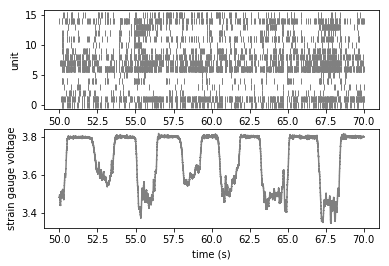

In [80]:
sample_rate = model.sample_rate
ltime = 50
rtime = 70
lsamples = ltime * sample_rate
rsamples = rtime * sample_rate


#plt.plot(d)
#plt.plot(intan_sync)
plt.subplot(2,1,1)
plt.plot(goodtimes[(goodtimes > ltime) & (goodtimes < rtime)],goodspikes[(goodtimes > ltime) & (goodtimes < rtime)],'|',color=[0.5,0.5,0.5])
plt.xlabel('time (s)')
plt.ylabel('unit')
plt.subplot(2,1,2)
plt.plot(np.arange(ltime,rtime,(rtime-ltime)/(rsamples-lsamples)),matlab_brush_extra_added[int(lsamples):int(rsamples)],color = [0.5, 0.5, 0.5])
plt.xlabel('time (s)')
plt.ylabel('strain gauge voltage')

In [15]:
def get_cluster_waveforms (kwik_model,cluster_id):
    try:
        if (not(type(kwik_model) is KwikModel)):
            raise ValueError       
    except ValueError:
            print ("Exception: the first argument should be a KwikModel object")
            return
        
    clusters = kwik_model.spike_clusters
    try:
        if ((not(cluster_id in clusters))):
            raise ValueError       
    except ValueError:
            print ("Exception: cluster_id (%d) not found !! " % cluster_id)
            return
    
    idx=np.argwhere (clusters==cluster_id)
    w=model.all_waveforms[idx]
    return w

def plot_cluster_waveforms (kwik_model,cluster_id,nspikes, save=False,save_path=None):
    
    w = get_cluster_waveforms (kwik_model,cluster_id)
    y_scale = 1
    x_scale = 1
    num_channels = w.shape[2]
    waveform_size = w.shape[1]
    np.random.seed()
    
    fig=plt.figure(num=None, figsize=(3, 6), facecolor='w', edgecolor='k')
    plt.clf()
    spike_id = np.arange(w.shape[0])
    np.random.shuffle(spike_id)
    spike_id = spike_id[0:nspikes]
    for ch in range (0,num_channels):
        x_offset = model.channel_positions [ch,0]
        y_offset = model.channel_positions [ch,1]*y_scale
        mu_spikes = np.mean(w[:,:,ch],0)
        for i in spike_id:
            spike = w[i,:,ch]
            x=x_scale*x_offset+range(0,waveform_size)
            #plt.plot (x,0.05*spike+y_offset,color="gray",alpha=0.5)
        plt.plot (x,0.05*mu_spikes+y_offset,"-",color="black",linewidth=1,alpha=0.3)
    plt.tight_layout()
    plt.show()
    if (save):
        if (save_path):
            filename = "%s/waveform_%02d.pdf" % (save_path,cluster_id)
        else:
            filename = "waveform_%02d.pdf" % cluster_id
        fig.savefig (filename)

In [ ]:
for cluster in good:
    plot_cluster_waveforms(model,cluster,1000,save=True)

In [16]:
def make_psth(bin_size,sample_rate, spiketimes, spikeclusters):
    # Use this to convert spike time rasters into PSTHs with user-defined bin
    # Output is organized in time x unit array
    bin_samples = bin_size * sample_rate
    max_bin = max(spiketimes) / bin_size
    num_units = max(goodspikes)
    psths = np.zeros([int(np.floor(max_bin)), num_units])
    for i in range(len(spikeclusters)):
        psths[int(np.floor(spiketimes[i]/bin_size))-1, spikeclusters[i]-1] += 1
    psth_dict = {}
    psth_dict['psths'] = psths/bin_size #in units of Hz
    psth_dict['bin_size'] = bin_size #in s
    psth_dict['sample_rate'] = sample_rate # in Hz
    return psth_dict

In [17]:
psth_dict = make_psth(0.25,sample_rate,goodtimes,goodspikes)
psths = psth_dict['psths']
psth_binsize = psth_dict['bin_size']

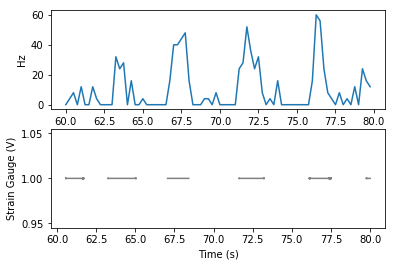

In [78]:
sample_rate = model.sample_rate
ltime = 60
rtime = 80
lsamples = ltime * sample_rate
rsamples = rtime * sample_rate

plt.subplot(211)
plt.plot(np.arange(ltime,rtime,psth_binsize),psths[int(ltime/psth_binsize):int(rtime/psth_binsize),12])
plt.ylabel('Hz')
plt.subplot(212)
plt.plot(np.arange(ltime,rtime,(rtime-ltime)/(rsamples-lsamples)),stim_on[int(lsamples):int(rsamples)],color = [0.5, 0.5, 0.5])
plt.xlabel('Time (s)')
plt.ylabel('Strain Gauge (V)')

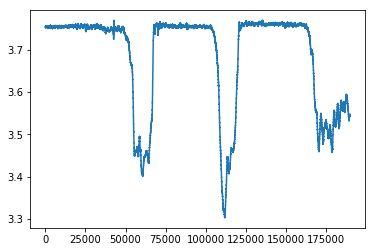

In [33]:
plt.plot(matlab_brush_extra_added[200000:390000])

In [72]:
baseline_strain = np.mean(matlab_brush_extra_added[150000:160000])
stim_on = np.zeros(len(matlab_brush_extra_added))
for i, valu in enumerate(matlab_brush_extra_added):
    if valu < baseline_strain * .97 or valu > baseline_strain * 1.03:
        stim_on[i] = 1
    else:
        stim_on[i] = np.nan
    if valu < 2:
        stim_on[i] = np.nan
        

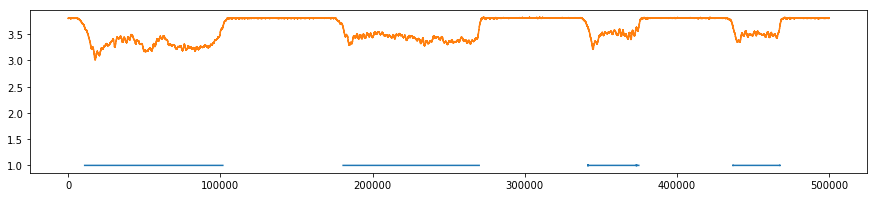

In [74]:
plt.figure(figsize=(15,3))
plt.plot(stim_on[2500000:3000000])
plt.plot(matlab_brush_extra_added[2500000:3000000])